# WALLABY admin notebook

Template Jupyter Notebook to provide users with full access to the WALLABY database.

## Credentials

Since this is an admin notebook, the admin will have to provide the password with admin access to the database. Without this password the user will only be granted read-only access to the database and will not be able to update the contents of the tables.

**NOTE**: Update the `admin_password` variable here.

In [1]:
# TODO(user): update password field here

admin_password = None
user_password = "LKaRsQrNtXZ7vN8L*6"

## Initialise Django

The following cells must be run first. They are used to import `django`, set up a connection to the database and import the Django models. Once these cells are run, you are able to use the Django model objects for access to the database.

In [2]:
# Essential Python libraries for using the ORM

import sys
import os
import django

In [3]:
# Database access environment variables

os.environ["DJANGO_SECRET_KEY"] = "-=(gyah-@e$-ymbz02mhwu6461zv&1&8uojya413ylk!#bwa-l"
os.environ["DJANGO_SETTINGS_MODULE"] = "api.settings"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "True"
os.environ["DATABASE_HOST"] = "146.118.67.204"
os.environ["DATABASE_NAME"] = "wallabydb"
os.environ["DATABASE_USER"] = "wallaby_user"
os.environ["DATABASE_PASSWORD"] = user_password if admin_password is None else admin_password

In [4]:
# Connect with SoFiAX_services Django ORM

sys.path.append('/mnt/shared/wallaby/apps/SoFiAX_services/api/')
django.setup()

In [5]:
# Import models

from tables.models import Run, Instance, Detection, Product, Source, SourceDetection

## Inspect detection

To check that the detections that are added to the database by the source finding application are legitimate sources it will be easiest to visualise it. We will do that now with Django to access the database. The steps will be as follows, each in their own cell below

1. List all detections for the Run
2. Select a detection from that list of detection
3. Retrieve products for that detection
4. Plot moment maps and spectra

In [6]:
# 1. Select all detection for a Run (let's choose Hydra_DR1 for this example). 

# First lets see what Runs are in the database, to confirm we have Hydra_DR1.
print(Run.objects.all())

# Next we get all detections for this Run
detections = Detection.objects.filter(run_id=Run.objects.get(name='Hydra_DR1').id)
print(detections)

<QuerySet [<Run: Hydra_DR1>, <Run: Hydra_DR2>, <Run: NGC4636_DR1>, <Run: Norma_DR1>]>
<QuerySet [<Detection: SoFiA_J104447-270553>, <Detection: SoFiA_J104512-284309>, <Detection: SoFiA_J104503-282709>, <Detection: SoFiA_J104356-244748>, <Detection: SoFiA_J104414-271548>, <Detection: SoFiA_J104410-270802>, <Detection: SoFiA_J104442-290119>, <Detection: SoFiA_J104432-290559>, <Detection: SoFiA_J104326-251857>, <Detection: SoFiA_J104311-261500>, <Detection: SoFiA_J104252-252014>, <Detection: SoFiA_J104359-293304>, <Detection: SoFiA_J104339-285157>, <Detection: SoFiA_J104334-284856>, <Detection: SoFiA_J104245-264738>, <Detection: SoFiA_J104254-273043>, <Detection: SoFiA_J104257-280352>, <Detection: SoFiA_J104309-300301>, <Detection: SoFiA_J104157-264302>, <Detection: SoFiA_J104246-295308>, '...(remaining elements truncated)...']>


In [7]:
# 2. Select a detection from these detections

detection = detections.get(id=1)
print(detection)

SoFiA_J104447-270553


In [8]:
# 3. Retrieve products

# First lets see what products we can expect
print(Product._meta.fields)

# Now retrieve a Product object
products = Product.objects.get(detection_id = detection.id)

(<django.db.models.fields.BigAutoField: id>, <django.db.models.fields.related.ForeignKey: detection>, <django.db.models.fields.BinaryField: cube>, <django.db.models.fields.BinaryField: mask>, <django.db.models.fields.BinaryField: mom0>, <django.db.models.fields.BinaryField: mom1>, <django.db.models.fields.BinaryField: mom2>, <django.db.models.fields.BinaryField: chan>, <django.db.models.fields.BinaryField: snr>, <django.db.models.fields.BinaryField: spec>)


In [9]:
# 4. Plotting

# We will provide a plotting script that actually doesn't make use of the products retrieved above. Instead, just provide the detection and they will be retrieved in the function below.

import io
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache

In [10]:
# Plotting functions that will be useful

def retrieve_dss_image(longitude, latitude, width, height):
    hdulist = SkyView.get_images(position="{}, {}".format(longitude, latitude), survey=["DSS"], coordinates="J2000", projection="Tan", pixels="{}, {}".format(str(int(2400 * width)), str(int(2400 * height))), width=width*u.deg, height=height*u.deg);
    return hdulist[0][0]

def plot_detection(detection):
    # Plot figure size    
    interval = PercentileInterval(95.0)
    plt.rcParams["figure.figsize"] = (12,12)
    
    # Retrieve products from database
    products = Product.objects.get(detection=detection)
    
    # Open moment 0 image
    with io.BytesIO() as buf:
        buf.write(products.mom0)
        buf.seek(0)
        hdu_mom0 = fits.open(buf)[0]
        wcs = WCS(hdu_mom0.header)
        mom0 = hdu_mom0.data

    # Open moment 1 image
    with io.BytesIO() as buf:
        buf.write(products.mom1)
        buf.seek(0)
        hdu_mom1 = fits.open(buf)[0]
        mom1 = hdu_mom1.data

    with io.BytesIO() as buf:
        buf.write(b''.join(products.spec))
        buf.seek(0)
        spectrum = np.loadtxt(buf, dtype="float", comments="#", unpack=True)

    # Extract coordinate information
    nx = hdu_mom0.header["NAXIS1"]
    ny = hdu_mom0.header["NAXIS2"]
    clon, clat = wcs.all_pix2world(nx/2, ny/2, 0)
    tmp1, tmp3 = wcs.all_pix2world(0, ny/2, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx, ny/2, 0)
    width = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    tmp1, tmp3 = wcs.all_pix2world(nx/2, 0, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx/2, ny, 0)
    height = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    
    # Download DSS image from SkyView
    hdu_opt = retrieve_dss_image(clon, clat, width, height)
    wcs_opt = WCS(hdu_opt.header)
    
    # Plot moment 0
    ax2 = plt.subplot(2, 2, 1, projection=wcs);
    ax2.imshow(mom0, origin="lower");
    ax2.grid(color="grey", ls="solid");
    ax2.set_xlabel("Right ascension (J2000)");
    ax2.set_ylabel("Declination (J2000)");
    ax2.tick_params(axis="x", which="both", left=False, right=False);
    ax2.tick_params(axis="y", which="both", top=False, bottom=False);
    ax2.set_title("moment 0");

    # Plot DSS image with HI contours
    bmin, bmax = interval.get_limits(hdu_opt.data);
    ax = plt.subplot(2, 2, 2, projection=wcs_opt);
    ax.imshow(hdu_opt.data, origin="lower");
    ax.contour(hdu_mom0.data, transform=ax.get_transform(wcs), levels=np.logspace(2.0, 5.0, 10), colors="lightgrey", alpha=1.0);
    ax.grid(color="grey", ls="solid");
    ax.set_xlabel("Right ascension (J2000)");
    ax.set_ylabel("Declination (J2000)");
    ax.tick_params(axis="x", which="both", left=False, right=False);
    ax.tick_params(axis="y", which="both", top=False, bottom=False);
    ax.set_title("DSS + moment 0");

    # Plot moment 1
    bmin, bmax = interval.get_limits(mom1);
    ax3 = plt.subplot(2, 2, 3, projection=wcs);
    ax3.imshow(hdu_mom1.data, origin="lower", vmin=bmin, vmax=bmax, cmap=plt.get_cmap("gist_rainbow"));
    ax3.grid(color="grey", ls="solid");
    ax3.set_xlabel("Right ascension (J2000)");
    ax3.set_ylabel("Declination (J2000)");
    ax3.tick_params(axis="x", which="both", left=False, right=False);
    ax3.tick_params(axis="y", which="both", top=False, bottom=False);
    ax3.set_title("moment 1");

    # Plot spectrum
    xaxis = spectrum[1] / 1e+6;
    data  = 1000.0 * np.nan_to_num(spectrum[2]);
    xmin = np.nanmin(xaxis);
    xmax = np.nanmax(xaxis);
    ymin = np.nanmin(data);
    ymax = np.nanmax(data);
    ymin -= 0.1 * (ymax - ymin);
    ymax += 0.1 * (ymax - ymin);
    ax4 = plt.subplot(2, 2, 4);
    ax4.step(xaxis, data, where="mid", color="royalblue");
    ax4.set_xlabel("Frequency (MHz)");
    ax4.set_ylabel("Flux density (mJy)");
    ax4.set_title("spectrum");
    ax4.grid(True);
    ax4.set_xlim([xmin, xmax]);
    ax4.set_ylim([ymin, ymax]);

    plt.suptitle(detection.name.replace("_", " ").replace("-", "−"), fontsize=16);
    plt.show();

    # Clean up
    clear_download_cache(pkgname="astroquery");
    clear_download_cache();

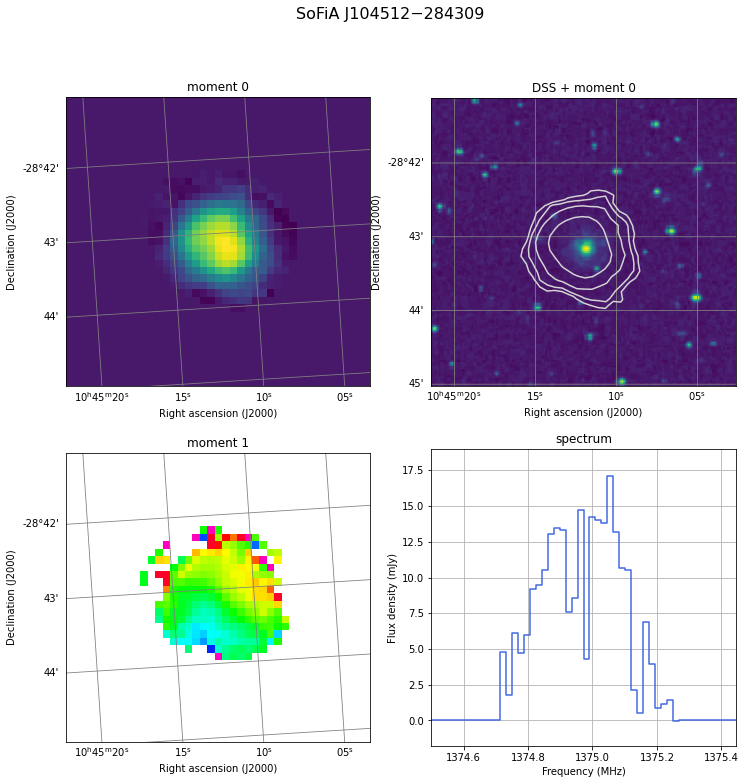

In [13]:
# Creating the plot

%matplotlib inline

plot_detection(Detection.objects.get(id=2))